In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd

In [2]:
import sklearn
from sklearn.linear_model import LinearRegression
#rom sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LassoLars

from sklearn.linear_model import TweedieRegressor

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
def get_ranks(good_df,ypred):
    cutoff=0.2
    #print (codedata,ypred,ydata)
    #print (len(ypred),len(good_df.mm.to_list()))
    d = {'code':good_df.code.to_list(),'pred':ypred,
         "dockQ":good_df.dockQ.to_list(),"params":good_df.params.to_list(),
        "mm":good_df.mm.to_list()}
    res_df=pd.DataFrame(d).sort_values("pred")
    #res_df.sort_values("CODE")

    i=0
    sumdiff=0
    mmdiff=0
    correct=0
    for code in res_df.code.unique():
        topranked=res_df.loc[res_df.code==code].sort_values("pred")["dockQ"][-1:].max()
        best=res_df.loc[res_df.code==code]["dockQ"].max()
        mmtop=res_df.loc[res_df.code==code].sort_values("pred")["mm"][-1:].max()
        mmbest=res_df.loc[res_df.code==code]["mm"].max()
        #print (code,topranked,best)
        if best>cutoff:
            i+=1
            sumdiff+=best-topranked
            mmdiff+=mmbest-mmtop
            if topranked>cutoff:
                correct+=1
    #print (i,correct,round(sumdiff/i,3))            
    return (i,correct,sumdiff,mmdiff)

In [4]:
reg = LinearRegression()
#reg=RandomForestClassifier(n_estimators=10)
#reg=LassoLars(alpha=.1)
#reg = TweedieRegressor(power=1, alpha=0.5, link='log')
#reg=TheilSenRegressor(random_state=42)
#reg=RANSACRegressor(random_state=42)
#reg=HuberRegressor()

In [5]:
df=pd.read_csv("~/Downloads/summary.csv",sep=",")
df=df.dropna()
#df.JHparams.unique()

In [6]:
sns.set(style="whitegrid")

In [7]:
df["name"]
df.keys()

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank'],
      dtype='object')

In [8]:

df["code"]=df["name"].str[:4]
df["CODE"]=df["code"]
df["params"]=df["JHparams"]
datasets=df.JHparams.unique()
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-cov90',
       'N1-merged-pdb', 'N1-merged', 'N1-N3-cov90', 'N1-N3-cov-nocov',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3-cov90',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts-new', 'pdbsurface', 'rbh-jh',
       'rbh-merged-pdb', 'rbh-merged', 'rbh', 'TMdock-double',
       'TMdock-nohomology'], dtype=object)

In [9]:

r=re.compile("^PDB|^pdb|^TMd|gramm")
datasets=df.JHparams.unique()
#notRosettaset=list(filter(r.match, datasets))
#df2=df.loc[~df.JHparams.isin(notRosettaset)].copy()
Rosettaset=['-N 1 -E 1.e-10 --cpu 8 ','-N 3 --cpu 8', 
            'N1-cov90','N3-cov90', 'N1-N3-multimerged', 'N1-N3-new', 'N1-N3-cov90', 'N1-N3-cov-nocov',
            'rbh-jh',"confold"] 
# We have to think which ones to use..
df2=df.loc[df.JHparams.isin(Rosettaset)].copy()
df2.JHparams="trRosetta"
df2.params="trRosetta"



In [10]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
#df.JHparams.unique()


,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
0,1ay7_u1_A-1ay7_u2_A,-N 3 --cpu 8,97,90,1060.0,1485.0,2034.0,1026.0,0.281,0.167,...,0.40,9999.00,0.000,0.4,0.400,0.4,1.0,1ay7,1ay7,-N 3 --cpu 8
1,1ay7_u2_A-1ay7_u1_A,-N 3 --cpu 8,90,97,1060.0,2034.0,1485.0,989.0,0.239,0.250,...,0.36,9999.00,0.000,0.0,9999.000,0.0,2.0,1ay7,1ay7,-N 3 --cpu 8
2,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733.0,1484.0,2034.0,654.0,0.223,0.120,...,0.46,4.30,50.000,1.8,0.027,13.5,1.0,1b27,1b27,-N 3 --cpu 8
3,1b27_u2_A-1b27_u1_A,-N 3 --cpu 8,90,109,733.0,2034.0,1484.0,656.0,0.229,0.160,...,0.46,4.30,50.000,2.5,0.019,13.7,2.0,1b27,1b27,-N 3 --cpu 8
4,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651.0,349880.0,23051.0,5071.0,0.000,0.000,...,0.00,9999.00,0.000,0.0,9999.000,0.0,1.0,1bdj,1bdj,-N 3 --cpu 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16459,4yoc_u2_A-4yoc_u1_A,trRosetta,530,905,12.0,4076.0,31492.0,12.0,0.007,0.000,...,0.00,0.76,24.390,0.6,0.600,0.6,2.0,4yoc,4yoc,trRosetta
16460,4zfr_u1_A-4zfr_u2_A,trRosetta,186,77,82.0,9290.0,38386.0,75.0,0.010,0.000,...,0.00,9999.00,0.000,0.0,9999.000,0.0,1.0,4zfr,4zfr,trRosetta
16461,4zfr_u2_A-4zfr_u1_A,trRosetta,77,186,82.0,38386.0,9290.0,73.0,0.016,0.000,...,0.00,9999.00,0.000,0.0,9999.000,0.0,2.0,4zfr,4zfr,trRosetta
16462,5brr_u1_A-5brr_u2_A,trRosetta,378,266,343.0,13553.0,45450.0,325.0,0.010,0.000,...,0.00,0.48,53.846,0.5,0.500,0.5,1.0,5brr,5brr,trRosetta


In [63]:
#df.loc[df.JHparams=="N1-N3-new"]
Dockingset=Rosettaset+["gramm","TMdock-double"]

In [12]:
r=re.compile("^PDB|^pdb")
datasets=df.JHparams.unique()
pdbset=list(filter(r.match, datasets))
df2=df.loc[(df.JHparams.isin(pdbset))&(~df.JHparams.isin(["pdbconfold"]))].copy()
df2.JHparams="PDB"
df2.params="PDB"
df2

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
9289,1ay7_u1_A-1ay7_u2_A,PDB,97,90,0.0,0.0,0.0,0.0,0.884,0.722,...,0.01,9999.00,0.000,0.4,0.4,0.4,1.0,1ay7,1ay7,PDB
9290,1ay7_u2_A-1ay7_u1_A,PDB,90,97,0.0,0.0,0.0,0.0,0.929,0.833,...,0.09,9999.00,0.000,0.0,9999.0,0.0,2.0,1ay7,1ay7,PDB
9291,1b27_u1_A-1b27_u2_A,PDB,109,90,0.0,0.0,0.0,0.0,0.861,0.740,...,0.01,4.30,50.000,1.8,1.8,1.8,1.0,1b27,1b27,PDB
9292,1b27_u2_A-1b27_u1_A,PDB,90,109,0.0,0.0,0.0,0.0,0.887,0.780,...,0.08,4.30,50.000,2.5,2.5,2.5,2.0,1b27,1b27,PDB
9293,1bdj_u1_A-1bdj_u2_A,PDB,129,118,0.0,0.0,0.0,0.0,0.790,0.882,...,0.00,9999.00,0.000,0.0,9999.0,0.0,1.0,1bdj,1bdj,PDB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9755,4ilh_u1_A-4ilh_u2_A,PDB,301,256,0.0,0.0,0.0,0.0,0.045,0.000,...,0.01,0.94,85.714,0.1,0.1,0.1,1.0,4ilh,4ilh,PDB
9756,4llo_u1_A-4llo_u2_A,PDB,147,115,0.0,0.0,0.0,0.0,0.081,0.040,...,0.10,17.00,27.273,0.0,9999.0,0.0,1.0,4llo,4llo,PDB
9757,4llo_u2_A-4llo_u1_A,PDB,115,147,0.0,0.0,0.0,0.0,0.099,0.200,...,0.01,17.00,27.273,0.0,9999.0,0.0,2.0,4llo,4llo,PDB
9758,5brr_u1_A-5brr_u2_A,PDB,378,266,0.0,0.0,0.0,0.0,0.002,0.000,...,0.05,0.48,53.846,0.5,0.5,0.5,1.0,5brr,5brr,PDB


In [13]:
df=pd.concat([df,df2], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-cov90',
       'N1-merged-pdb', 'N1-merged', 'N1-N3-cov90', 'N1-N3-cov-nocov',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3-cov90',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts-new', 'pdbsurface', 'rbh-jh',
       'rbh-merged-pdb', 'rbh-merged', 'rbh', 'TMdock-double',
       'TMdock-nohomology', 'trRosetta', 'PDB'], dtype=object)

In [14]:
# Add a linear combination of trRosetta
# Does not work
r=re.compile(".*-N.*") # .*cpu.*
datasets=Rosettaset
#JHsets=list(filter(r.match, datasets))



In [15]:
cutoff=0.2
goodmodels=df.loc[(df.dockQ>cutoff)&(df.JHparams.isin(Rosettaset))].code.unique()
good_df=df.loc[(df.code.isin(goodmodels))&(df.JHparams.isin(Rosettaset))] #.reset_index()
#df.dockQ.dtypes

In [16]:
ydata=good_df.dockQ

#cols=["lenA","lenB","msa","long","med","longA","medA","longB","medB","tmA","tmB"]
#xdata=good_df[["lenA","lenB","long","med"]]
#cols=["longA","longB","medA","medB","tmA","tmB"]
cols=["med","long","msa"]
#cols=["msa"]
xdata=good_df[cols]
reg.fit(xdata,ydata)
ypred = reg.predict(xdata)
#f, ax = plt.subplots(figsize=(6.5, 6.5))
#plt.scatter(ydata,ypred)
cc=np.corrcoef(ydata,ypred)
#ax.set_xlabel("dockQ")
#ax.set_ylabel("predicted dockQ")
(i,j,dockq,mm)=get_ranks(good_df,ypred)
#print(i,j,k/i)
#ax.set_title("CC" + " " + str(round(cc[0,1],3))
#            + " Good: " + str(round(j/i,3)) + " Loss: " + str(round(dockq/i,3))
#             + " , " + str(round(mm/i,3))
#             + " Test: " + str(i)
#            )


In [17]:
xdata=df.loc[df.JHparams.isin(Rosettaset)][cols]
ypred = reg.predict(xdata)
df2=df.loc[df.JHparams.isin(Rosettaset)].reset_index()
df2.loc[:,'pred'] = ypred
topranked=pd.DataFrame(columns = df2.columns) 


In [18]:

for name in df2.name.unique():
    foo=df2.loc[df2.name==name].sort_values("pred")[-1:].max()
    #print(foo)
    foo_df=pd.DataFrame(foo).transpose()
    #print (foo_df)
    topranked=pd.concat([topranked,foo_df], ignore_index=True)
topranked["JHparams"]="JHranked"
topranked.params="JHranked"
topranked=topranked.drop(["pred","index"],axis=1)
topranked.columns

Index(['name', 'JHparams', 'lenA', 'lenB', 'msa', 'msaA', 'msaB', 'cdhit',
       'dockQ', 'fnat', 'iRMS', 'LRMS', 'fnonnat', 'mm', 'tmA', 'tmB', 'long',
       'med', 'longPPV', 'medPPV', 'longA', 'medA', 'longPPVA', 'medPPVA',
       'longB', 'medB', 'longPPVB', 'medPPVB', 'short', 'shortPPV', 'shortA',
       'shortPPVA', 'shortB', 'shortPPVB', 'shortpdb', 'medpdb', 'longpdb',
       'avprob', 'auc', 'evalue', 'seqid', 'hhprob', 'hhevalue', 'hhscore',
       'rank', 'code', 'CODE', 'params'],
      dtype='object')

In [19]:
#topranked

In [20]:
df=pd.concat([df,topranked], ignore_index=True,sort=False)
df.fillna(0)
df.params.unique()

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-cov90',
       'N1-merged-pdb', 'N1-merged', 'N1-N3-cov90', 'N1-N3-cov-nocov',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3-cov90',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts-new', 'pdbsurface', 'rbh-jh',
       'rbh-merged-pdb', 'rbh-merged', 'rbh', 'TMdock-double',
       'TMdock-nohomology', 'trRosetta', 'PDB', 'JHranked'], dtype=object)

In [21]:
df

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,auc,evalue,seqid,hhprob,hhevalue,hhscore,rank,code,CODE,params
0,1ay7_u1_A-1ay7_u2_A,-N 3 --cpu 8,97,90,1060,1485,2034,1026,0.281,0.167,...,0.4,9999,0,0.4,0.4,0.4,1,1ay7,1ay7,-N 3 --cpu 8
1,1ay7_u2_A-1ay7_u1_A,-N 3 --cpu 8,90,97,1060,2034,1485,989,0.239,0.25,...,0.36,9999,0,0,9999,0,2,1ay7,1ay7,-N 3 --cpu 8
2,1b27_u1_A-1b27_u2_A,-N 3 --cpu 8,109,90,733,1484,2034,654,0.223,0.12,...,0.46,4.3,50,1.8,0.027,13.5,1,1b27,1b27,-N 3 --cpu 8
3,1b27_u2_A-1b27_u1_A,-N 3 --cpu 8,90,109,733,2034,1484,656,0.229,0.16,...,0.46,4.3,50,2.5,0.019,13.7,2,1b27,1b27,-N 3 --cpu 8
4,1bdj_u1_A-1bdj_u2_A,-N 3 --cpu 8,129,118,5651,349880,23051,5071,0,0,...,0,9999,0,0,9999,0,1,1bdj,1bdj,-N 3 --cpu 8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,5cec_u2_A-5cec_u1_A,JHranked,191,403,4,59695,200,3,0.028,0.028,...,0,19,33.333,0.3,0.3,0.3,2,5cec,5cec,JHranked
17375,5cra_u1_A-5cra_u2_A,JHranked,193,77,1,11,38383,1,0.008,0,...,0,9999,0,1,1,1,1,5cra,5cra,JHranked
17376,5cra_u2_A-5cra_u1_A,JHranked,77,193,1,38383,11,1,0.097,0,...,0.17,9999,0,0.8,0.8,0.8,2,5cra,5cra,JHranked
17377,5eg3_u1_A-5eg3_u2_A,JHranked,303,105,264,147816,3955,73,0.006,0,...,0,68,40,0.9,0.9,0.9,1,5eg3,5eg3,JHranked


In [22]:
#df["rank"].str.isnumeric().unique()
#df.dtypes

In [23]:
# We need to check that everything is numeric
#cols=['name', 'JHparams', 'seqid',      'rank']

#for d in df.columns.values.tolist():
for d in ["rank","len"]:
    if d=="name": continue
    if d=="JHparams": continue
    print (d)
    print (df.loc[(df[d].str.isnumeric()!=True)][cols+[d]])
    #print (df.loc[(df[d].str.isnumeric()][d].unique()
    print (df[d].str.isnumeric().unique())

rank


AttributeError: Can only use .str accessor with string values!

In [24]:
# Divide data into datasets


df["tmAB"]=df[["tmA","tmB"]].mean(axis=1)
df["msaAB"]=df[["msaA","msaB"]].mean(axis=1)
df["tmAB_max"]=df[["tmA","tmB"]].max(axis=1)
df["msaAB_max"]=df[["msaA","msaB"]].max(axis=1)
df["tmAB_min"]=df[["tmA","tmB"]].min(axis=1)
df["msaAB_min"]=df[["msaA","msaB"]].min(axis=1)
df["numcorrect"]=df["longPPV"]*df["long"]
df["len"]=df["lenA"]+df["lenB"]

codes=df.code.unique()
df_mean=df.groupby(["JHparams","code"]).mean()
df_max=df.groupby(["JHparams","code"]).max()
df_min=df.groupby(["JHparams","code"]).min()
df_first=df.loc[df["rank"]==1]

In [25]:
#df.columns.values.tolist()
#df["rank"]==1


0         True
1        False
2         True
3        False
4         True
         ...  
17374    False
17375     True
17376    False
17377     True
17378    False
Name: rank, Length: 17379, dtype: bool

In [26]:
cols=['name', 'JHparams', 'seqid',      'rank']
      
#d="TMdock-nohomology"
#df.loc[df.JHparams==d].groupby(["code"])[cols].first()

#df.loc[(df.JHparams==d) & ((df["rank"].str.isnumeric()!=True))][cols]
#df.loc[(df.JHparams==d)]["rank"].str.isnumeric()
#df.loc[(df.JHparams==d)] 
      
      

In [27]:
datasets=df.JHparams.unique()
data_mean={}
data_max={}
data_min={}
for d in datasets:
    print (d)
    data_mean[d]=df.loc[df.JHparams==d].groupby(["code"]).mean()
    data_max[d]=df.loc[df.JHparams==d].groupby(["code"]).max()
    data_min[d]=df.loc[df.JHparams==d].groupby(["code"]).min()


-N 3 --cpu 8


confold


gramm


homodimer


ispred


-N 1 -E 1.e-100 --cpu 8


-N 1 -E 1.e-2 


N1-cov90


N1-merged-pdb


N1-merged


N1-N3-cov90


N1-N3-cov-nocov


N1-N3-merged-fast


N1-N3-new


N1-N3-multimerged


-N 1 -E 1.e-10 --cpu 8 


N1-top1000-merged


N1-top1000


N1-top100


N1-top2000


N1-top500


N3-cov90


-N 3 --incE 1.e-2


N3-merged


N3-multimerged


-N 5 --cpu 8


pdbconfold


pdbcontacts-new


pdbsurface


rbh-jh


rbh-merged-pdb


rbh-merged


rbh


TMdock-double


TMdock-nohomology
trRosetta


PDB


JHranked


In [28]:
#df.loc[ (df.JHparams=="trRosetta")  & (df["rank"]==1)]

In [29]:
#df.JHparams.unique()
datasets

array(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred',
       '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-cov90',
       'N1-merged-pdb', 'N1-merged', 'N1-N3-cov90', 'N1-N3-cov-nocov',
       'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged',
       '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000',
       'N1-top100', 'N1-top2000', 'N1-top500', 'N3-cov90',
       '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', '-N 5 --cpu 8',
       'pdbconfold', 'pdbcontacts-new', 'pdbsurface', 'rbh-jh',
       'rbh-merged-pdb', 'rbh-merged', 'rbh', 'TMdock-double',
       'TMdock-nohomology', 'trRosetta', 'PDB', 'JHranked'], dtype=object)

In [30]:
data_first={}
data_second={}
for d in datasets:
    data_first[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==1)]
    data_second[d]=df.loc[ (df["JHparams"]==d)  & (df["rank"]==2)]
data_first["trRosetta"]

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
12634,1ay7_u1_A-1ay7_u2_A,trRosetta,97,90,1060,1485,2034,1026,0.281,0.167,...,1ay7,trRosetta,0.828190,1759.5,0.84625,2034.0,0.81013,1485.0,53.985,187
12636,1b27_u1_A-1b27_u2_A,trRosetta,109,90,733,1484,2034,654,0.223,0.12,...,1b27,trRosetta,0.824750,1759.0,0.85428,2034.0,0.79522,1484.0,49.025,199
12638,1bdj_u1_A-1bdj_u2_A,trRosetta,129,118,5651,349880,23051,5071,0,0,...,1bdj,trRosetta,0.861435,186465.5,0.92240,349880.0,0.80047,23051.0,0,247
12640,1buh_u1_A-1buh_u2_A,trRosetta,291,72,1177,555226,1820,548,0,0,...,1buh,trRosetta,0.560760,278523.0,0.73259,555226.0,0.38893,1820.0,0,363
12642,1bvn_u1_A-1bvn_u2_A,trRosetta,496,75,95,52623,123,85,0.006,0,...,1bvn,trRosetta,0.619740,26373.0,0.70905,52623.0,0.53043,123.0,0,571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16454,4y7m_u1_A-4y7m_u2_A,trRosetta,240,136,2,1124,44484,2,0.017,0,...,4y7m,trRosetta,0.248485,22804.0,0.26058,44484.0,0.23639,1124.0,0,376
16456,4yeb_u1_A-4yeb_u2_A,trRosetta,322,257,63,376641,3146,44,0,0,...,4yeb,trRosetta,0.697280,189893.5,0.78098,376641.0,0.61358,3146.0,0,579
16458,4yoc_u1_A-4yoc_u2_A,trRosetta,905,530,12,31492,4076,12,0.007,0,...,4yoc,trRosetta,0.203720,17784.0,0.21985,31492.0,0.18759,4076.0,0,1435
16460,4zfr_u1_A-4zfr_u2_A,trRosetta,186,77,82,9290,38386,75,0.01,0,...,4zfr,trRosetta,0.688690,23838.0,0.78427,38386.0,0.59311,9290.0,0,263


In [31]:
#datasets
d

'JHranked'

In [32]:
df_test= data_first["N1-cov90"]
#data_first["N1-merged"].tmA
df_test["tmB"]


3715    0.46284
3717    0.63038
3719    0.78949
3721    0.54834
3723    0.17686
         ...   
4148    0.42238
4150    0.70269
4152    0.56894
4154    0.70704
4156    0.56993
Name: tmB, Length: 222, dtype: object

In [33]:
df_merged = pd.merge(data_first["trRosetta"],data_first[d], on=['code'],how="inner")
#plt.scatter(data_first["trRosetta"].dockQ,data_first["trRosetta"].mm)

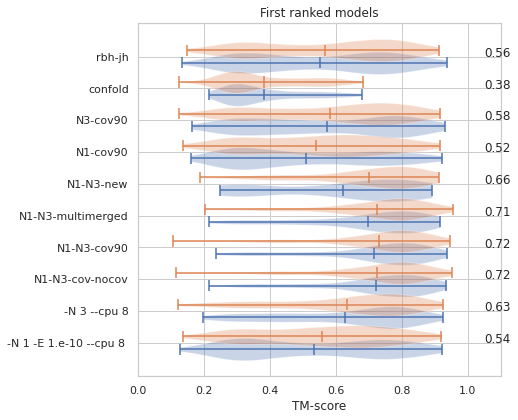

In [75]:
# FInd best method for each model.
selset=Rosettaset
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))

all_df=df_first.loc[(df_first.params.isin(selset))].reset_index()
all_df.sort_values("JHparams")
#print (all_df)
#plt.scatter(all_df.tmA,all_df.JHparams,color="red")
ax.set_title("First ranked models")
#ax.set_ylabel("Method")
ax.set_xlabel("TM-score")
ax.set(xlim=[0,1.1])
done={}
average=[]
length={}
pos=[]
posA=[]
posB=[]
POS=[]
i=0
dataA=[]
dataB=[]
keys=[]
shift=0.2
for d in sorted(selset,reverse=False):
    #done[d]=0
    average+=[0.5*(all_df.loc[(all_df.params==d)]["tmA"].mean()+all_df.loc[(all_df.params==d)]["tmB"].mean())]
    #length[d]=len(all_df.loc[(all_df.params==d)]["tmA"])
    pos+=[i]
    posA+=[i-shift]
    posB+=[i+shift]
    keys+=[d]
    POS+=[[i]*len(data[i])]
    dataA+=[all_df.loc[(all_df.JHparams==d)]["tmA"].to_list()]
    dataB+=[all_df.loc[(all_df.JHparams==d)]["tmB"].to_list()]
    #print (d,i,len(pos),pos[i],len(data),len(data[i]))
    i+=1
ax.set_yticklabels(keys)
ax.set_yticks(pos)
for i in range(len(dataA)):
    #plt.scatter(dataA[i],POS[i],color="red")
    #plt.scatter(dataB[i],POS[i],color="red")
    sstr=str(round(average[i],2))
    ax.annotate(sstr,(1.05, i))
    #numgood=all (x > cutoffC for x in data[i])
    #ax.annotate("High:  "+str(numgood),(.8, i))

ax.violinplot(dataA,posA, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
ax.violinplot(dataB,posB, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    
plt.savefig("violin-TM.png")


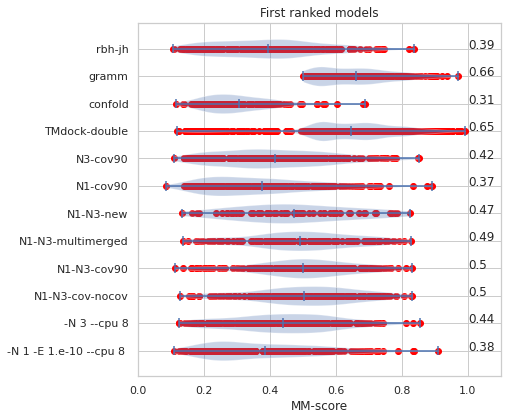

In [82]:
# FInd best method for each model.
selset=Dockingset
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))

all_df=df_first.loc[(df_first.params.isin(selset))].reset_index()
all_df.sort_values("JHparams")
#print (all_df)
#plt.scatter(all_df.tmA,all_df.JHparams,color="red")
ax.set_title("First ranked models")
#ax.set_ylabel("Method")
ax.set_xlabel("MM-score")
ax.set(xlim=[0,1.1])
done={}
average=[]
length={}
pos=[]
POS=[]
i=0
data=[]
keys=[]
shift=0.2
for d in sorted(selset,reverse=False):
    #done[d]=0
    average+=[all_df.loc[(all_df.params==d)]["mm"].mean()]
    #length[d]=len(all_df.loc[(all_df.params==d)]["tmA"])
    pos+=[i]
    keys+=[d]
    data+=[all_df.loc[(all_df.JHparams==d)]["mm"].to_list()]
    POS+=[[i]*len(data[i])]
    #print (d,i,len(pos),pos[i],len(data),len(data[i]))
    i+=1
ax.set_yticklabels(keys)
ax.set_yticks(pos)
#print (data,POS)
cutoff=0.5
#cutoffA=0.5
#cutoffB=0.49
#cutoffC=0.80

for i in range(len(data)):
    plt.scatter(data[i],POS[i],color="red")
    numgood=len([x for x in data[i] if x>cutoff])
    sstr=str(round(average[i],2))
    ax.annotate(sstr,(1., i))
    #numgood=all (x > cutoffC for x in data[i])
    #ax.annotate("High:  "+str(numgood),(.8, i))

ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    

plt.savefig("violin-MM.png")


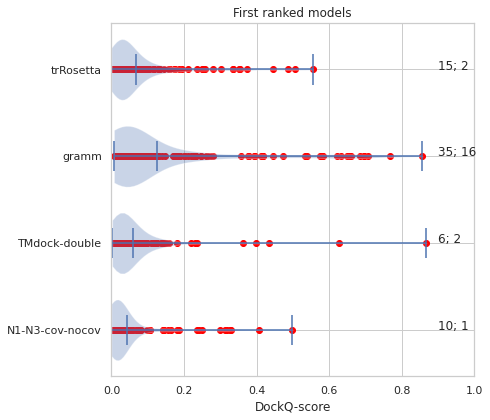

In [94]:
selset=["N1-N3-cov-nocov","trRosetta","gramm","TMdock-double"]
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))

all_df=df_max.loc[(df_max.params.isin(selset))].reset_index()
all_df.sort_values("JHparams")
#print (all_df)
#plt.scatter(all_df.tmA,all_df.JHparams,color="red")
ax.set_title("First ranked models")
#ax.set_ylabel("Method")
ax.set_xlabel("DockQ-score")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
POS=[]
i=0
data=[]
keys=[]
shift=0.2
for d in sorted(selset,reverse=False):
    #done[d]=0
    #average[d]=all_df.loc[(all_df.params==d)]["tmA"].mean()
    #length[d]=len(all_df.loc[(all_df.params==d)]["tmA"])
    pos+=[i]
    keys+=[d]
    data+=[all_df.loc[(all_df.JHparams==d)]["dockQ"].to_list()]
    POS+=[[i]*len(data[i])]
    #print (d,i,len(pos),pos[i],len(data),len(data[i]))
    i+=1
ax.set_yticklabels(keys)
ax.set_yticks(pos)
#print (data,POS)
cutoff=0.23
cutoffA=0.23
cutoffB=0.49
cutoffC=0.80

for i in range(len(data)):
    plt.scatter(data[i],POS[i],color="red")
    numgoodA=len([x for x in data[i] if x>cutoffA])
    numgoodB=len([x for x in data[i] if x>cutoffB])
    sstr=str(numgoodA)+"; "+str(numgoodB)
    ax.annotate(sstr,(.9, i))
    #numgood=all (x > cutoffC for x in data[i])
    #ax.annotate("High:  "+str(numgood),(.8, i))

ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    

plt.savefig("violin-dockQ-best.png")


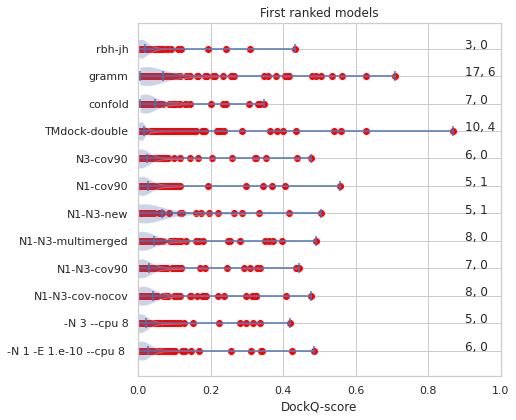

In [65]:
# FInd best method for each model.
selset=Dockingset
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))

all_df=df_first.loc[(df_first.params.isin(selset))].reset_index()
all_df.sort_values("JHparams")
#print (all_df)
#plt.scatter(all_df.tmA,all_df.JHparams,color="red")
ax.set_title("First ranked models")
#ax.set_ylabel("Method")
ax.set_xlabel("DockQ-score")
ax.set(xlim=[0,1])
done={}
average={}
length={}
pos=[]
POS=[]
i=0
data=[]
keys=[]
shift=0.2
for d in sorted(selset,reverse=False):
    #done[d]=0
    #average[d]=all_df.loc[(all_df.params==d)]["tmA"].mean()
    #length[d]=len(all_df.loc[(all_df.params==d)]["tmA"])
    pos+=[i]
    keys+=[d]
    data+=[all_df.loc[(all_df.JHparams==d)]["dockQ"].to_list()]
    POS+=[[i]*len(data[i])]
    #print (d,i,len(pos),pos[i],len(data),len(data[i]))
    i+=1
ax.set_yticklabels(keys)
ax.set_yticks(pos)
#print (data,POS)
cutoff=0.23
cutoffA=0.23
cutoffB=0.49
cutoffC=0.80

for i in range(len(data)):
    plt.scatter(data[i],POS[i],color="red")
    numgoodA=len([x for x in data[i] if x>cutoffA])
    numgoodB=len([x for x in data[i] if x>cutoffB])
    sstr=str(numgoodA)+"; "+str(numgoodB)
    ax.annotate(sstr,(.9, i))
    #numgood=all (x > cutoffC for x in data[i])
    #ax.annotate("High:  "+str(numgood),(.8, i))

ax.violinplot(data,pos, points=80, vert=False, widths=0.7,
                      showmeans=True, showextrema=True, showmedians=False)    

plt.savefig("violin-dockQ.png")


# This is the first plot to save
#df_test= data_first["N1-merged"]
#plt.scatter(df_test.tmB,df_test.tmA)
#sns_plot = sns.jointplot(data=df_test, x="tmA", y="tmB")
#sns_plot.savefig("tmA-tmB.png")








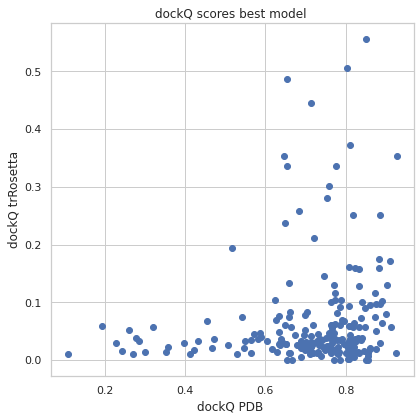

In [267]:
#df_test.loc[(df_test.tmA>0.8 )&(df_test.lenA>300)]["name"]
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
df_merged = pd.merge(data_max["PDB"],data_max["trRosetta"], on=['code'],how="inner")
plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
ax.set_title("dockQ scores best model ")
ax.set_xlabel("dockQ PDB ")
ax.set_ylabel("dockQ trRosetta")
plt.savefig("trRosetta-PDB-dockQ.png")


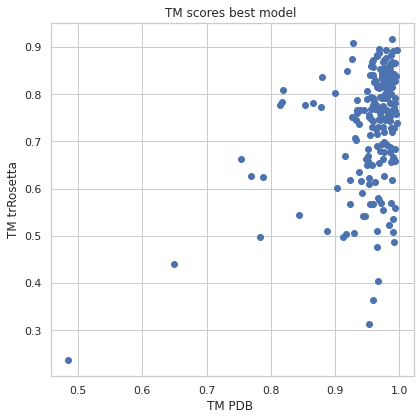

In [83]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
df_merged = pd.merge(data_max["PDB"],data_max["trRosetta"], on=['code'],how="inner")
plt.scatter(df_merged.tmAB_x,df_merged.tmAB_y,label=d)
ax.set_title("TM scores best model ")
ax.set_xlabel("TM PDB ")
ax.set_ylabel("TM trRosetta")
plt.savefig("trRosetta-PDB-TMscore.png")



Text(0, 0.5, 'dockQ')

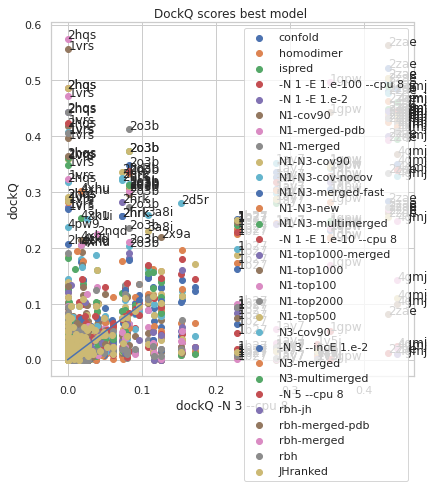

Text(0, 0.5, 'numcorrect')

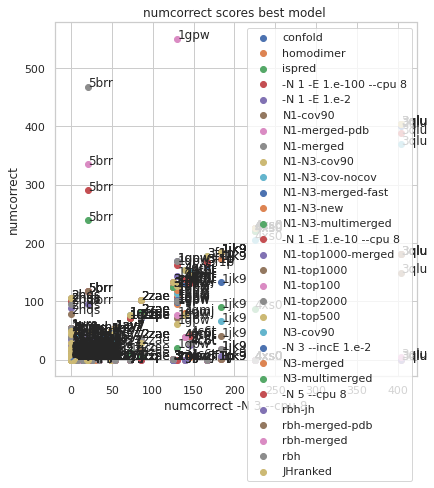

In [84]:

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

Text(0, 0.5, 'dockQ')

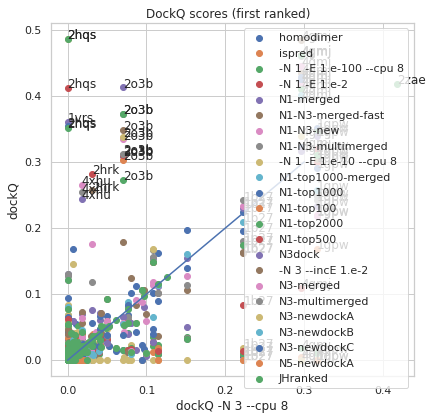

Text(0, 0.5, 'dockQ')

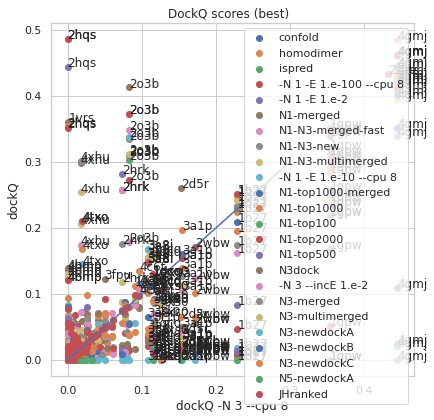

KeyError: 'N1-merged-pdb'

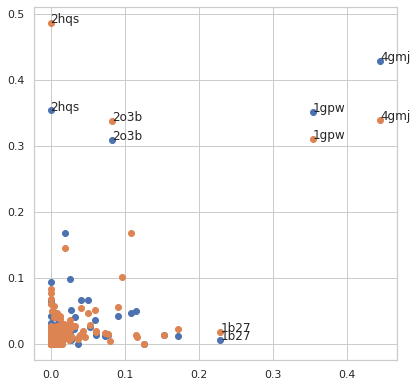

KeyError: 'N1-merged-pdb'

In [85]:
data_max.keys()

dict_keys(['-N 3 --cpu 8', 'confold', 'gramm', 'homodimer', 'ispred', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ', 'N1-cov90', 'N1-merged-pdb', 'N1-merged', 'N1-N3-cov90', 'N1-N3-cov-nocov', 'N1-N3-merged-fast', 'N1-N3-new', 'N1-N3-multimerged', '-N 1 -E 1.e-10 --cpu 8 ', 'N1-top1000-merged', 'N1-top1000', 'N1-top100', 'N1-top2000', 'N1-top500', 'N3-cov90', '-N 3 --incE 1.e-2', 'N3-merged', 'N3-multimerged', '-N 5 --cpu 8', 'pdbconfold', 'pdbcontacts-new', 'pdbsurface', 'rbh-jh', 'rbh-merged-pdb', 'rbh-merged', 'rbh', 'TMdock-double', 'TMdock-nohomology', 'trRosetta', 'PDB', 'JHranked'])

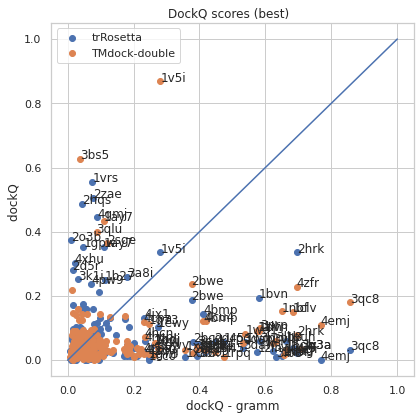

In [96]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

plt.savefig("tr-tm-gramm-best.png")


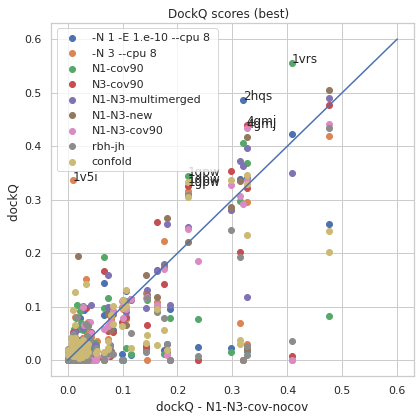

In [138]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
baseset="N1-N3-cov-nocov"
for d in Rosettaset:
    if d==baseset:continue   
    #print (d)
    df_merged = pd.merge(data_first[baseset],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        #if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
        if (df_merged.dockQ_y[i]> cutoff and ( df_merged.dockQ_y[i]-0.1>df_merged.dockQ_x[i])):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,.6]
y=[0,0.6]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (best)  ")
ax.set_xlabel("dockQ - "+baseset)
ax.set_ylabel("dockQ ")

plt.savefig("Trrosetta-first.png")


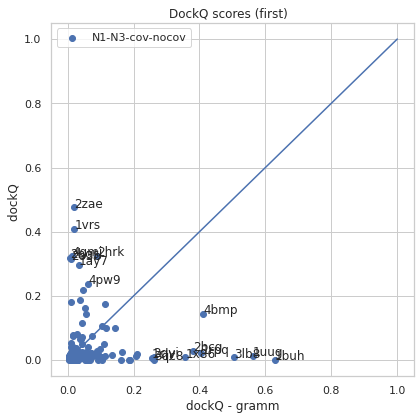

In [89]:
cutoff=0.23
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["N1-N3-cov-nocov","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_first["gramm"],data_first[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,1.0]
y=[0,1.0]
plt.plot(x,y)
ax.legend()
ax.set_title("DockQ scores (first)  ")
ax.set_xlabel("dockQ - gramm")
ax.set_ylabel("dockQ ")

plt.savefig("tr-tm-gramm-first.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

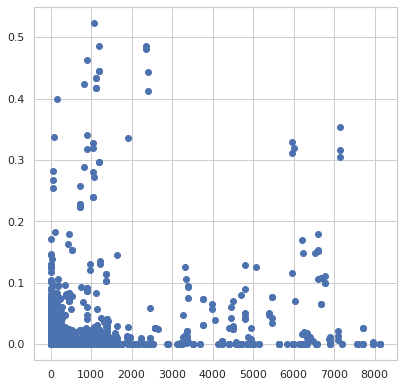

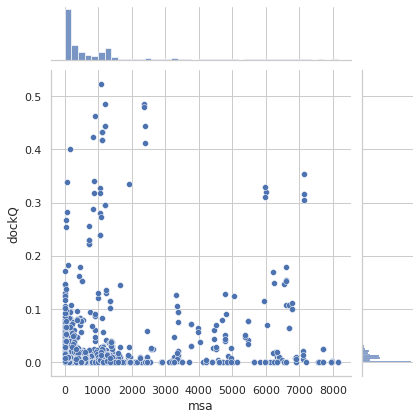

In [97]:
selset=['-N 3 --cpu 8', '-N 1 -E 1.e-100 --cpu 8', '-N 1 -E 1.e-2 ',  '-N 1 -E 1.e-10 --cpu 8 ',  '-N 3 --incE 1.e-2', '-N 5 --cpu 8']
#codes=df_max.loc[df_max.params.isin(selset)]["CODE"].unique()
f, ax = plt.subplots(figsize=(6.5, 6.5))
tempdf=df.loc[(df.JHparams.isin(selset))]
plt.scatter(tempdf.msa,tempdf.dockQ)
plt.savefig("msa-dockq-scatter.png")
sns_plot=sns.jointplot(data=tempdf,x="msa",y="dockQ")
sns_plot.savefig("msa-dockq.png")


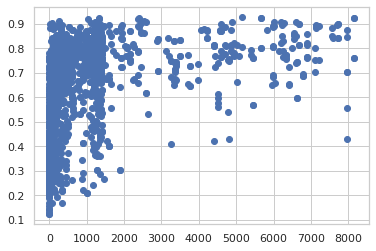

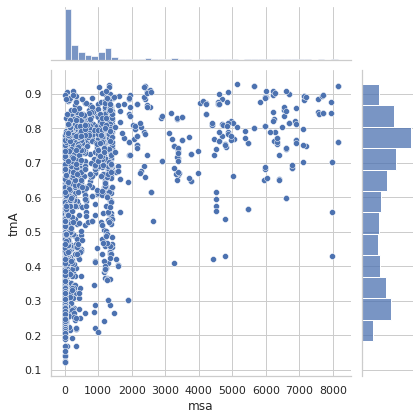

In [98]:
tempdf=df.loc[(df.JHparams.isin(selset))]
plt.scatter(tempdf.msa,tempdf.tmA)
#print (tempdf["msaA"])
#tempdf["logmsaA"]=np.log10(tempdf["msa"]+0.0000001)
plt.savefig("msa-tm-scatter.png")
sns_plot=sns.jointplot(data=tempdf,x="msa",y="tmA")
sns_plot.savefig("msa-tm.png")


NameError: name 'newdf' is not defined

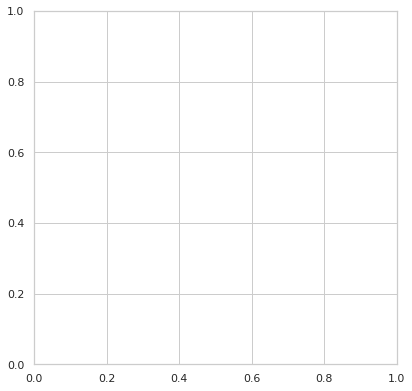

NameError: name 'newdf' is not defined

N1-N3-new
TMdock-double
gramm
[116    0.174
117    0.115
118     0.22
119    0.012
120    0.006
121    0.023
122    0.021
123    0.013
124    0.014
125    0.008
126        0
127    0.007
128    0.021
129    0.334
130    0.013
131    0.014
132    0.032
133    0.118
134     0.03
135    0.012
136    0.014
137    0.037
138    0.057
139    0.029
140     0.02
141    0.013
142    0.013
143    0.121
144    0.417
145     0.01
146    0.028
147    0.265
148    0.006
Name: dockQ, dtype: object, Series([], Name: dockQ, dtype: object), 0      0.113
1      0.628
2       0.01
3      0.045
4      0.016
       ...  
111    0.144
112    0.008
113    0.018
114    0.011
115    0.018
Name: dockQ, Length: 116, dtype: object]


KeyError: 0

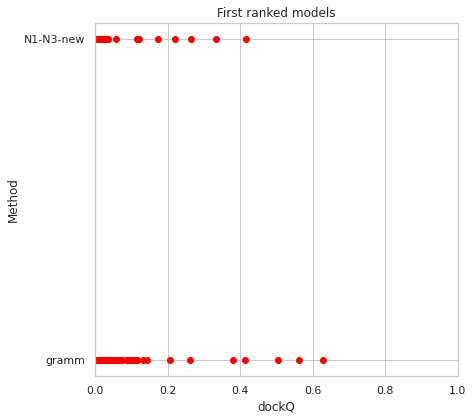

KeyError: 0

In [447]:
# FInd best method for each model.


Text(0, 0.5, 'dockQ ')

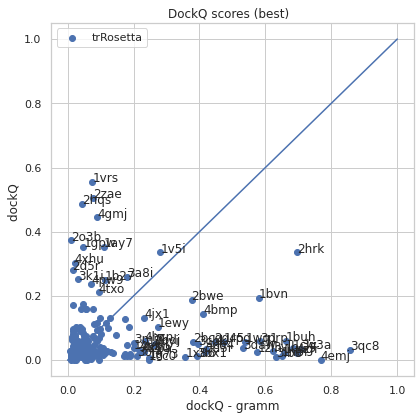

array([False])

TMdock-double
2210 2210
trRosetta
1766 1766


Text(20.200000000000003, 0.5, 'dockQ TMdock')

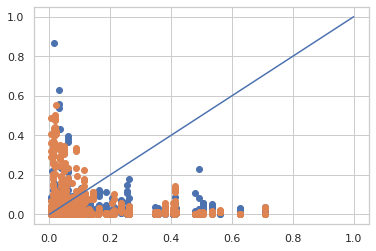

In [103]:

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

In [451]:

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock-nohomology'

Text(0, 0.5, 'dockQ TMdock')

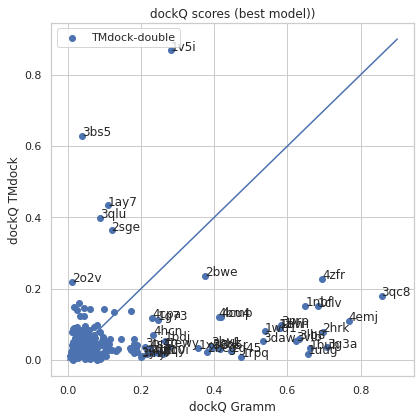

In [104]:


#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock-double'

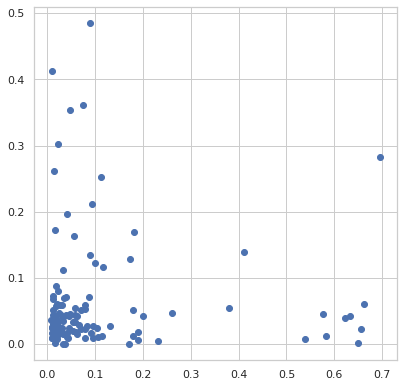

KeyError: 'TMdock-double'

In [453]:
cutoff=0.2
f, ax = plt.subplots(figsize=(6.5, 6.5))
for d in ["trRosetta","TMdock-double"]:
    #if d!="N1-merged":continue   
    #print (d)
    df_merged = pd.merge(data_max["gramm"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)

In [106]:
df_merged = df_max[df_max["params"].isin(["trRosetta","gramm","TMdock-double"])]
#df_merged.sort_values("dockQ")

In [107]:
len(df_merged.loc[df_merged.dockQ>0.2]["CODE"].unique())

58

In [108]:
len(df_merged.loc[(df_merged.params=="trRosetta")&(df_merged.dockQ>0.2 )]["CODE"].unique())

16

In [109]:
len(df_merged.loc[(df_merged.params=="gramm")&(df_merged.dockQ>0.2 )]["CODE"].unique())

40

In [110]:
len(df_merged.loc[(df_merged.params=="TMdock-double")&(df_merged.dockQ>0.2 )]["CODE"].unique())

8

In [111]:
len(df_merged["CODE"].unique())

222

In [112]:
df.loc[df.params=="TMdock-double"].sort_values("dockQ")

,name,JHparams,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,...,CODE,params,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
10606,1i4e_u1_A-1i4e_u2_A,TMdock-double,296,241,0,0,0,0,0,0,...,1i4e,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,537
10915,1y64_u1_A-1y64_u2_A,TMdock-double,412,361,0,0,0,0,0,0,...,1y64,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,773
12461,4v2c_u1_A-4v2c_u2_A,TMdock-double,324,107,0,0,0,0,0,0,...,4v2c,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,431
10791,1rpq_u1_A-1rpq_u2_A,TMdock-double,174,22,0,0,0,0,0,0,...,1rpq,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,196
11428,2xwb_u1_A-2xwb_u2_A,TMdock-double,711,229,0,0,0,0,0,0,...,2xwb,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10406,1ay7_u1_A-1ay7_u2_A,TMdock-double,97,90,0,0,0,0,0.434,0.417,...,1ay7,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,53.985,187
11485,3bs5_u1_A-3bs5_u2_A,TMdock-double,84,76,0,0,0,0,0.539,0.9,...,3bs5,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,160
11491,3bs5_u1_A-3bs5_u2_A,TMdock-double,84,76,0,0,0,0,0.56,0.7,...,3bs5,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,160
11490,3bs5_u1_A-3bs5_u2_A,TMdock-double,84,76,0,0,0,0,0.628,0.833,...,3bs5,TMdock-double,1.0,0.0,1.0,0.0,1.0,0.0,0,160


In [113]:
df_merged.groupby(["CODE"]).median().sort_values("dockQ")


,lenA,lenB,msa,msaA,msaB,cdhit,dockQ,fnat,iRMS,LRMS,...,hhscore,rank,tmAB,msaAB,tmAB_max,msaAB_max,tmAB_min,msaAB_min,numcorrect,len
CODE,,,,,,,,,,,,,,,,,,,,,
2xwb,711.0,229.0,0.0,0.0,0.0,0.0,0.010,0.000,32.953,90.617,...,278.0,5.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,940.0
2v55,388.0,180.0,0.0,0.0,0.0,0.0,0.011,0.000,65.638,133.825,...,10.9,5.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,568.0
2a41,373.0,259.0,0.0,0.0,0.0,0.0,0.011,0.000,66.088,168.705,...,10.1,2.0,0.77734,0.0,1.0,0.0,0.76305,0.0,0.000,632.0
4yoc,905.0,530.0,0.0,0.0,0.0,0.0,0.011,0.014,50.312,108.231,...,22.3,2.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,1435.0
3oed,295.0,131.0,0.0,0.0,0.0,0.0,0.011,0.000,81.354,186.204,...,0.0,2.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,426.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4zfr,186.0,77.0,0.0,0.0,0.0,0.0,0.229,0.375,22.956,56.231,...,0.0,2.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,263.0
2bwe,78.0,47.0,0.0,0.0,0.0,0.0,0.236,0.074,53.411,103.851,...,1.9,2.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,125.0
2hrk,181.0,121.0,0.0,0.0,0.0,0.0,0.336,0.326,14.905,55.266,...,141.4,5.0,1.00000,0.0,1.0,0.0,1.00000,0.0,0.000,302.0


Text(0, 0.5, 'dockQ TMdock')

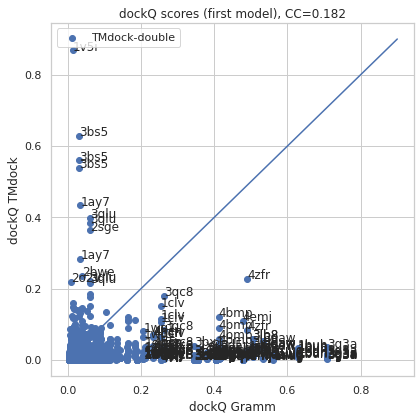

In [114]:
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/arnee/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Text(0, 0.5, 'dockQ TMdock TMdock-double')

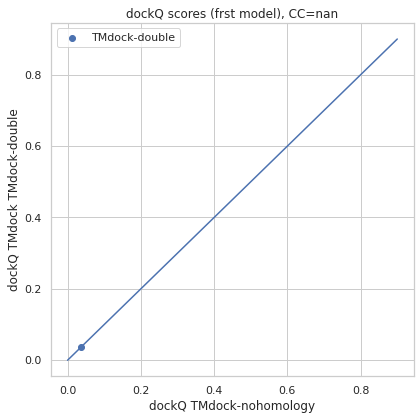

In [115]:

#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)

KeyError: 'TMdock'

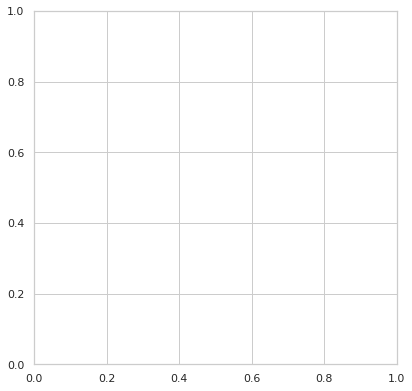

KeyError: 'TMdock'

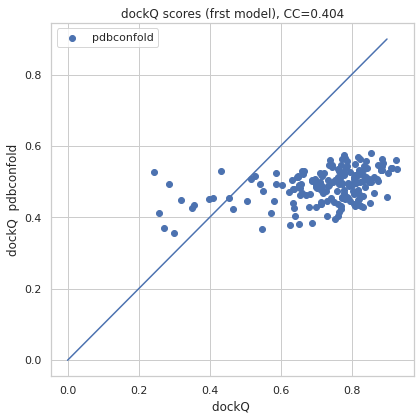

In [ ]:
cutoff=1.0
f, ax = plt.subplots(figsize=(6.5, 6.5))
r=re.compile("^PDB|^pdb")
pdbset=list(filter(r.match, datasets))
pdbset=["pdbconfold"]

for d in pdbset:
    #if d!="N1-merged":continue   
    #print (d)
    if d=="pdbcontacts-new":continue
    df_merged = pd.merge(data_max["pdbcontacts-new"],data_max[d], on=['code'],how="inner")
    #print (df_merged)
    #newdf=df_merged["dockQ_x","dockQ_y"]  #.loc[(df_merged.dockQ_x>cutoff or df_merged.dockQ_y>cutoff) ]
    cc=np.corrcoef(df_merged.dockQ_x,df_merged.dockQ_y)
    #print (cc)
    
    
    plt.scatter(df_merged.dockQ_x,df_merged.dockQ_y,label=d)
    for i, txt in enumerate(df_merged.name_x):
        #print (i,txt)
        try: 
            sstr=txt[0:4]
        except:
            sstr=df_merged.name_y[i][0:4]
        if (df_merged.dockQ_x[i]> cutoff or df_merged.dockQ_y[i]>cutoff):
            ax.annotate(sstr, (df_merged.dockQ_x[i], df_merged.dockQ_y[i]))
x=[0,0.9]
y=[0,0.9]
plt.plot(x,y)
ax.legend()
ax.set_title("dockQ scores (frst model), CC=" + str(round(cc[0,1],3)) )
ax.set_xlabel("dockQ ")
ax.set_ylabel("dockQ  "+d)
plt.savefig("pdbconfold.png")
#cat.add_categories([1])
#df_merged.fillna(0, inplace =True)